In [1]:
# set up libraries we'll need
import pandas as pd
import regex as re
import string
import csv

In [2]:
# import and preview dataset
# dataset from https://www.ire.org/events-and-training/conferences/nicar-2019
dataset = pd.read_csv('data/car19guide.csv')
dataset.head()

,event_id,name,clean_description,location_room,start_date_clean,start_time,end_time,pre_reg_flag,paid_flag,laptop_flag,speakers_cleaned,session_type,keywords,skill_level,session_title
0,4178,(Generally) painless collaboration with the gr...,Traditional reporters and editors often view t...,Salon A&B,2019-03-09,2019-03-09 15:30:00,2019-03-09 16:30:00,False,False,False,"Ryann Grochowski Jones, ProPublica (moderator)...",Panel,NaN,General interest,(Generally) painless collaboration with the gr...
1,4162,25th CAR: What a ride it's been!,Buckle up for a fast-paced ride through 25 yea...,Salon C&D,2019-03-08,2019-03-08 15:30:00,2019-03-08 16:30:00,False,False,False,"Doug Haddix, IRE/NICAR; Shawn McIntosh, Atlant...",Panel,NaN,General interest,25th CAR: What a ride it's been!
2,4189,50 databases to request right now,Get your FOI templates ready to roll. In this ...,Salon D,2019-03-09,2019-03-09 14:15:00,2019-03-09 15:15:00,False,False,False,"Mark Walker, The New York Times; Kate Martin, ...",Panel,NaN,General interest,50 databases to request right now
3,4198,A conversation with James B. Steele: Insights ...,This special session features the wit and wisd...,Salon A&B,2019-03-09,2019-03-09 10:15:00,2019-03-09 11:15:00,False,False,False,"Sarah Cohen, ASU Cronkite School of Journalism...",Panel,NaN,NaN,A conversation with James B. Steele: Insights ...
4,4301,Adding a text editor to your CAR toolkit,A good text editor is an essential tool for da...,Salon A&B,2019-03-10,2019-03-10 10:15:00,2019-03-10 11:15:00,False,False,False,"Agustin Armendariz, The New York Times",Demo,NaN,Intermediate,Adding a text editor to your CAR toolkit


In [3]:
# create new dataset with only the fields we want
subset = dataset.loc[:, ['name','clean_description']] # 'session_title' seems to be same as name
# add a column with the year
subset['conference_year'] = '2019'
subset.head()

,name,clean_description,conference_year
0,(Generally) painless collaboration with the gr...,Traditional reporters and editors often view t...,2019
1,25th CAR: What a ride it's been!,Buckle up for a fast-paced ride through 25 yea...,2019
2,50 databases to request right now,Get your FOI templates ready to roll. In this ...,2019
3,A conversation with James B. Steele: Insights ...,This special session features the wit and wisd...,2019
4,Adding a text editor to your CAR toolkit,A good text editor is an essential tool for da...,2019


In [4]:
# through manual analysis of the schedule, I found some that are not classes or are duplicate sessions
# these rows have names containing strings we can filter out using pipe
# thanks to https://stackoverflow.com/questions/11350770/select-by-partial-string-from-a-pandas-dataframe

filter_out = ['registration', 'sales', 'repeat']
filtered_subset = subset[~subset['name'].str.contains('|'.join(filter_out))]
# reset indices
filtered_subset = filtered_subset.reset_index(drop=True)

In [5]:
# preliminary text exploration
# fetch word count for each description
pd.options.mode.chained_assignment = None # get rid of warning...

filtered_subset['word_count'] = filtered_subset['clean_description'].apply(lambda x: len(str(x).split(" ")))
filtered_subset[['clean_description','word_count']].head()

,clean_description,word_count
0,Traditional reporters and editors often view t...,68
1,Buckle up for a fast-paced ride through 25 yea...,99
2,Get your FOI templates ready to roll. In this ...,56
3,This special session features the wit and wisd...,194
4,A good text editor is an essential tool for da...,49


In [6]:
# descriptive statistics of word counts
filtered_subset.word_count.describe()

count    225.000000
mean      81.973333
std       37.831383
min        3.000000
25%       58.000000
50%       75.000000
75%       98.000000
max      210.000000
Name: word_count, dtype: float64

In [7]:
# copy descriptions to new column for pre-processing
filtered_subset['preproc_desc'] = filtered_subset['clean_description']

# # make every word in descriptions lowercase
# filtered_subset['preproc_desc'] = filtered_subset['preproc_desc'].apply(lambda x: x.lower())
# # remove punctuation before looking for common/uncommon words because adjacent punctuation changes words
# filtered_subset['preproc_desc'] = filtered_subset['preproc_desc'].apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))
# filtered_subset['preproc_desc'].head()

In [8]:
# identify common words
# could be used for custom stop word list
freq = pd.Series(' '.join(filtered_subset['preproc_desc']).split()).value_counts()[:50]
freq
# only domain-specific words that we might want to keep out of stoplist are 'data', 'learn', 'stories'

and        756
to         653
the        512
a          385
of         335
data       258
you        246
for        245
is         241
in         232
with       213
will       207
how        197
your       180
This       153
session    140
that       136
this       123
on         118
be         117
can        108
or         105
are         95
good        91
who         79
have        73
as          70
from        67
an          65
some        64
for:        64
use         61
using       60
into        58
about       57
at          56
it          56
We'll       51
but         48
In          46
learn       46
more        45
—           44
what        43
also        43
their       42
tools       41
get         41
stories     39
data.       39
dtype: int64

In [9]:
# identify uncommon words
# inform cleaning needed?
unfreq =  pd.Series(' '.join(filtered_subset 
         ['preproc_desc']).split()).value_counts()[-20:]
unfreq

HTML/CSS       1
Webster        1
broadcast,     1
Stanford       1
Though         1
categorize     1
forget         1
thin           1
Does           1
Simple         1
6:30           1
Did            1
mastered       1
transition     1
names          1
SQLite.        1
before.        1
Overcoming     1
comparison.    1
Publishing     1
dtype: int64

In [10]:
# https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34
# libraries for text-preprocessing

# download these the first time you run this
#nltk.download('stopwords')
#nltk.download('wordnet') 

from nltk.corpus import stopwords
# stemming normalizes text by removing suffixes
from nltk.stem.porter import PorterStemmer
# lemmatisation works based on the root of the word.
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

In [11]:
# creating a list of stop words (plus adding custom stopwords if we want)
stop_words = set(stopwords.words("english"))# creating a list of custom stopwords
new_words = []
stop_words = stop_words.union(new_words)

In [12]:
# with the stopwords, clean and normalize the corpus
corpus = []
for i in range(0, filtered_subset['preproc_desc'].count()): # don't hard code number of rows!
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', filtered_subset['preproc_desc'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    ps=PorterStemmer()    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

In [13]:
# view an example corpus item
print(corpus[1])
print()
print(corpus[5])

buckle fast paced ride year data journalism told people drove car mainstream investigative reporting hear pivotal moment bizarre twist befuddled bureaucrat know hit featuring special guest expected guest speaker include crina boros center investigative journalism sarah cohen asu walter cronkite school journalism steve doig asu walter cronkite school journalism jaimi dowdell reuters mark horvit university missouri brant houston university illinois clarence jones independent journalist jennifer lafleur investigative reporting workshop james b steele independent journalist

much openrefine clustering faceting feature session deep dive grel openrefine expression language equivalent excel formula thorough introduction grel syntax review common function explore clean dataset function covered session include replace split concatenate string comparison cell cross join multiple project together foreach session good people familiar openrefine least excel experience introduction openrefine check 

In [42]:
# # testing if "r" shows up
# sub = ' r '
# print('\n'.join(s for s in corpus if sub in s))

In [14]:
# get word counts for every single word in the corpus
# https://www.geeksforgeeks.org/python-count-occurrences-of-each-word-in-given-text-file-using-dictionary/

# create an empty dictionary
counts = dict()

for desc in corpus: 
    # remove leading spaces
    desc = desc.strip() 
  
    # split the line into words 
    words = desc.split(" ") 
    
    for word in words:
        # Check if the word is already in dictionary 
        if word in counts: 
            # Increment count of word by 1 
            counts[word] = counts[word] + 1
        else: 
            # Add the word to dictionary with count 1 
            counts[word] = 1

In [15]:
# sort dictionary by word count values
import collections

sorted_counts_list = sorted(counts.items(), key=lambda x: x[1])
sorted_counts = collections.OrderedDict(sorted_counts_list)

In [16]:
# print dictionary of word counts
# https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value

print("There are " + str(len(sorted_counts.keys()))+ " unique words in this corpus.")
for key in list(sorted_counts.keys()): 
    print(key, ":", sorted_counts[key]) 

There are 2587 unique words in this corpus.
desk : 1
unapproachable : 1
shoot : 1
stack : 1
magically : 1
bouncing : 1
head : 1
revamp : 1
reputation : 1
perception : 1
buckle : 1
told : 1
drove : 1
mainstream : 1
pivotal : 1
bizarre : 1
twist : 1
befuddled : 1
bureaucrat : 1
hit : 1
featuring : 1
crina : 1
boros : 1
steve : 1
doig : 1
jaimi : 1
dowdell : 1
reuters : 1
mark : 1
horvit : 1
missouri : 1
brant : 1
houston : 1
illinois : 1
clarence : 1
jennifer : 1
lafleur : 1
geek : 1
overlooked : 1
appreciated : 1
wit : 1
accomplished : 1
inquirer : 1
largest : 1
magazine : 1
slew : 1
inc : 1
vanity : 1
fair : 1
arizona : 1
ran : 1
shared : 1
medal : 1
allowing : 1
inspect : 1
tidy : 1
seamlessly : 1
cm : 1
clustering : 1
equivalent : 1
thorough : 1
covered : 1
concatenate : 1
foreach : 1
least : 1
questioning : 1
sub : 1
neat : 1
unnatural : 1
occur : 1
incident : 1
lengthy : 1
frustrating : 1
intimidate : 1
appeal : 1
freedom : 1
terrorist : 1
jason : 1
leopold : 1
attorney : 1
katie :

represent : 1
believe : 1
draw : 1
elicit : 1
flip : 1
wish : 1
binder : 1
exercise : 1
cheat : 1
easily : 1
reasonable : 1
comfort : 1
comprehensive : 1
typo : 1
enrich : 1
party : 1
wikidata : 1
reconciliation : 1
lab : 1
separately : 1
charles : 1
minshew : 1
hannah : 1
fresques : 1
sandhya : 1
kambhampati : 1
maryjo : 1
webster : 1
minneapolis : 1
star : 1
tribune : 1
fuss : 1
podcast : 1
listener : 1
documentcloud : 1
slidetrack : 1
annotate : 1
photo : 1
hundred : 1
transparency : 1
indexed : 1
grant : 1
employee : 1
personnel : 1
probably : 1
sue : 1
demoing : 1
added : 1
model : 1
protocol : 1
regarding : 1
storage : 1
browsing : 1
accordingly : 1
addressing : 1
low : 1
hanging : 1
fruit : 1
mitigating : 1
sophisticated : 1
relatively : 1
keyboard : 1
contain : 1
digitized : 1
root : 1
object : 1
confusing : 1
master : 1
nice : 1
topojson : 1
connecting : 1
switching : 1
exposed : 1
networking : 1
parental : 1
childcare : 1
balance : 1
failed : 1
lost : 1
sight : 1
cardinal : 1

syntax : 4
string : 4
feel : 4
date : 4
always : 4
publication : 4
birth : 4
rate : 4
million : 4
context : 4
spatial : 4
paper : 4
step : 4
putting : 4
planning : 4
pay : 4
ask : 4
behind : 4
police : 4
agency : 4
rape : 4
impact : 4
collection : 4
published : 4
animation : 4
publishing : 4
advice : 4
panelist : 4
sport : 4
easier : 4
handy : 4
us : 4
released : 4
connection : 4
industry : 4
away : 4
kind : 4
privacy : 4
mean : 4
count : 4
nearly : 4
tactic : 4
decision : 4
leadership : 4
merge : 4
csv : 4
future : 4
studio : 4
continuation : 4
digging : 4
pre : 4
registered : 4
material : 4
registration : 4
education : 4
parse : 4
security : 4
threat : 4
hate : 4
conduct : 4
calculation : 4
yes : 4
minute : 4
sometimes : 4
taken : 4
format : 4
tidyverse : 4
plot : 4
ggplot : 4
save : 4
recent : 4
coming : 4
dns : 4
uncover : 4
turning : 4
beginning : 4
management : 4
cs : 4
standard : 4
previous : 4
desktop : 4
backend : 4
principle : 4
handle : 4
technical : 4
geocode : 4
spot : 4
n

In [35]:
# write dictionary to a csv file

# with open('data/car19_keywords_dups.csv', 'w') as f:
#     for key in sorted_counts.keys():
#         f.write("%s,%s\n"%(key,sorted_counts[key]))

In [17]:
# take 2
# get word counts for every word BUT only counting each word ONCE per description
# https://www.geeksforgeeks.org/python-ways-to-remove-duplicates-from-list/

# create an empty dictionary
counts_no_dups = dict()

for desc in corpus: 
    # remove leading spaces
    desc = desc.strip() 
  
    # split the line into words 
    words = desc.split(" ") 
    
    # remove duplicates within a description
    words_no_dups = [i for n, i in enumerate(words) if i not in words[:n]] 
    
    for word in words_no_dups:
        # Check if the word is already in dictionary 
        if word in counts_no_dups: 
            # Increment count of word by 1 
            counts_no_dups[word] = counts_no_dups[word] + 1
        else: 
            # Add the word to dictionary with count 1 
            counts_no_dups[word] = 1
            
sorted_counts_list_no_dups = sorted(counts_no_dups.items(), key=lambda x: x[1])
sorted_counts_no_dups = collections.OrderedDict(sorted_counts_list_no_dups)

# print("Counting each word once per description, there are " + str(len(sorted_counts_no_dups.keys())) + " unique words in this corpus.")
# for key in list(sorted_counts_no_dups.keys()): 
#     print(key, ":", sorted_counts_no_dups[key]) 

# # write to csv file
# with open('data/car19_keywords_nodups.csv', 'w') as f:
#     for key in sorted_counts_no_dups.keys():
#         f.write("%s,%s\n"%(key,sorted_counts_no_dups[key]))

In [59]:
# # write both counts to a new csv file
# with open('data/car19_keywords_manual_both.csv', 'w', newline='') as csv_writer:
#     keywords_writer = csv.writer(csv_writer, delimiter=',')
#     with open('data/car19_keywords_manual.csv') as csv_file:
#         csv_reader = csv.reader(csv_file, delimiter=',')
#         for row in csv_reader:
#             # print("%s appears %s time(s)"%(row[0],row[1]))
#             keyword = row[0]
#             nodups_value = sorted_counts_no_dups[keyword]
#             new_row = row + [nodups_value]
#             keywords_writer.writerow(new_row)

In [35]:
both_keyword_counts = pd.read_csv('data/car19_keywords_manual_both.csv', header=None)
both_keyword_counts.head()

,0,1,2
0,csvkit,1,1
1,pivottables,1,1
2,pdfs,1,1
3,tidyr,1,1
4,readr,1,1


In [36]:
both_keyword_counts.tail()

,0,1,2
65,python,31,18
66,spreadsheet,32,25
67,r,35,18
68,excel,39,24
69,database,61,37


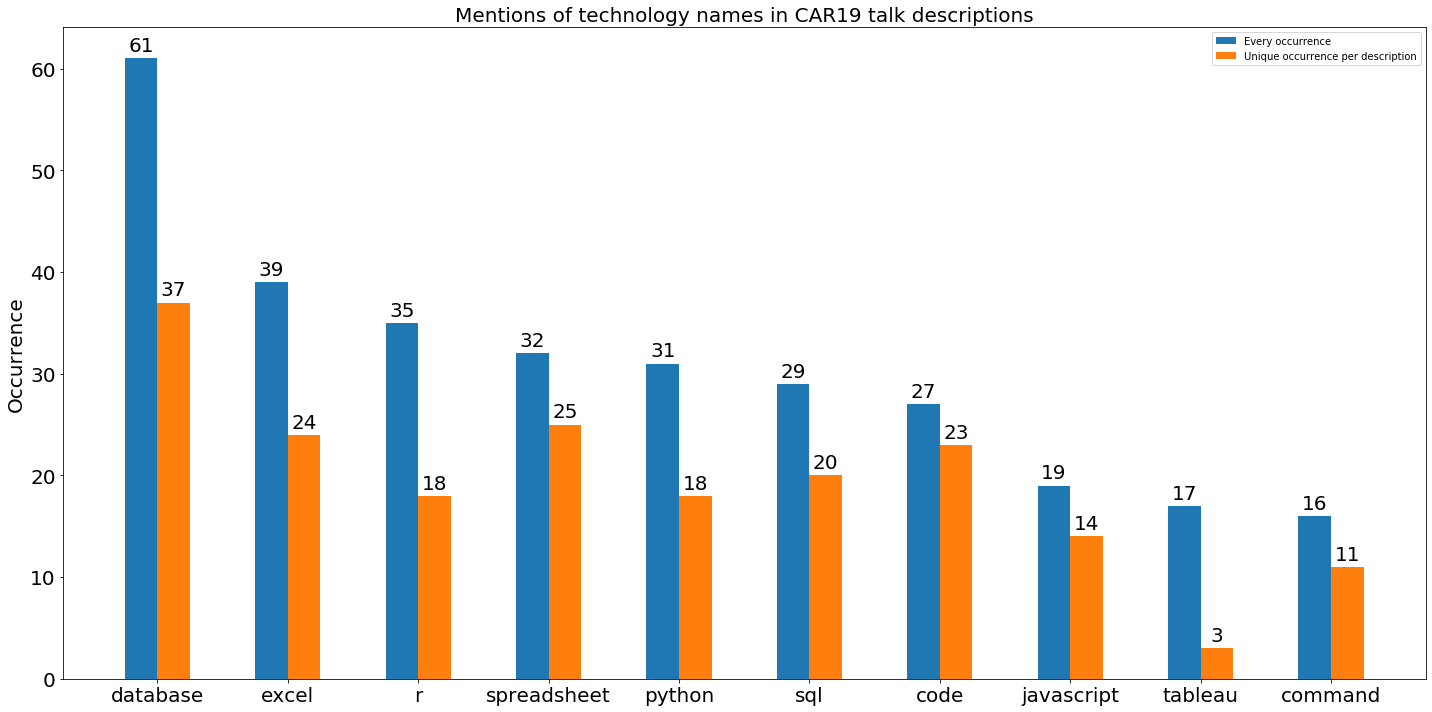

In [43]:
# graph the data
# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html
import matplotlib.pyplot as plt
import numpy as np

labels = both_keyword_counts[0].values[::-1][:10]
all_freq = both_keyword_counts[1].values[::-1][:10]
once_freq = both_keyword_counts[2].values[::-1][:10]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 10))
rects1 = ax.bar(x - width/2, all_freq, width, label='Every occurrence')
rects2 = ax.bar(x + width/2, once_freq, width, label='Unique occurrence per description')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Occurrence')
ax.set_title('Mentions of technology names in CAR19 talk descriptions')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize='20')


autolabel(rects1)
autolabel(rects2)

# increase fon tsize
# http://ishxiao.com/blog/python/2017/07/23/how-to-change-the-font-size-on-a-matplotlib-plot.html
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

fig.tight_layout()

plt.show()